<a href="https://colab.research.google.com/github/fintech-projects/google-colab/blob/main/create_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the key libraries

In [1]:
import numpy as np
import os 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
import io

print (tf.__version__)

2.6.0


# Importing the data

In [2]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json 
!kaggle datasets download -d koryakinp/fingers
from zipfile import ZipFile
file_name = "fingers.zip"

Saving kaggle.json to kaggle.json
 97% 354M/363M [00:02<00:00, 153MB/s]
100% 363M/363M [00:02<00:00, 129MB/s]


In [3]:
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


# Organizing the data into folders

In [4]:
import glob

Pngfiles_Train = []
Pngfiles_Test = []

os.chdir('/content/train')

for files in glob.glob("*.png"):
  Pngfiles_Train.append(files)

os.chdir('/content/test')

for files in glob.glob("*.png"):
  Pngfiles_Test.append(files)

In [5]:
Classes = ['0L', '1L', '2L', '3L', '4L', '5L', '0R', '1R', '2R', '3R', '4R', '5R']

if not os.path.exists('/content/Train'):
  os.mkdir('/content/Train')

if not os.path.exists('/content/Test'):
  os.mkdir('/content/Test')

In [6]:
for i in Classes:
  if not os.path.exists('/content/Train/'+i):
    os.mkdir('/content/Train/'+i)

for i in Classes:
  if not os.path.exists('/content/Test/'+i):
    os.mkdir('/content/Test/'+i)

In [7]:
# Training set

import shutil

os.chdir('/content/train') # change directory for train data

for i in Pngfiles_Train:
  last_two = i[-6:-4]
  shutil.copy(i, '/content/Train/{}'.format(last_two))

os.chdir('/content/test') # change directory for testing data
for i in Pngfiles_Test:
  last_two = i[-6:-4]
  shutil.copy(i, '/content/Test/{}'.format(last_two))

# Importing the Training dataset

In [8]:
Batch_size = 32
Image_size = (128,128)

training_set = tf.keras.preprocessing.image_dataset_from_directory(directory = '/content/Train',
                                                                   batch_size = Batch_size,
                                                                   image_size = Image_size,
                                                                   label_mode = 'categorical')

Found 18000 files belonging to 12 classes.


### Visualizing the imported results

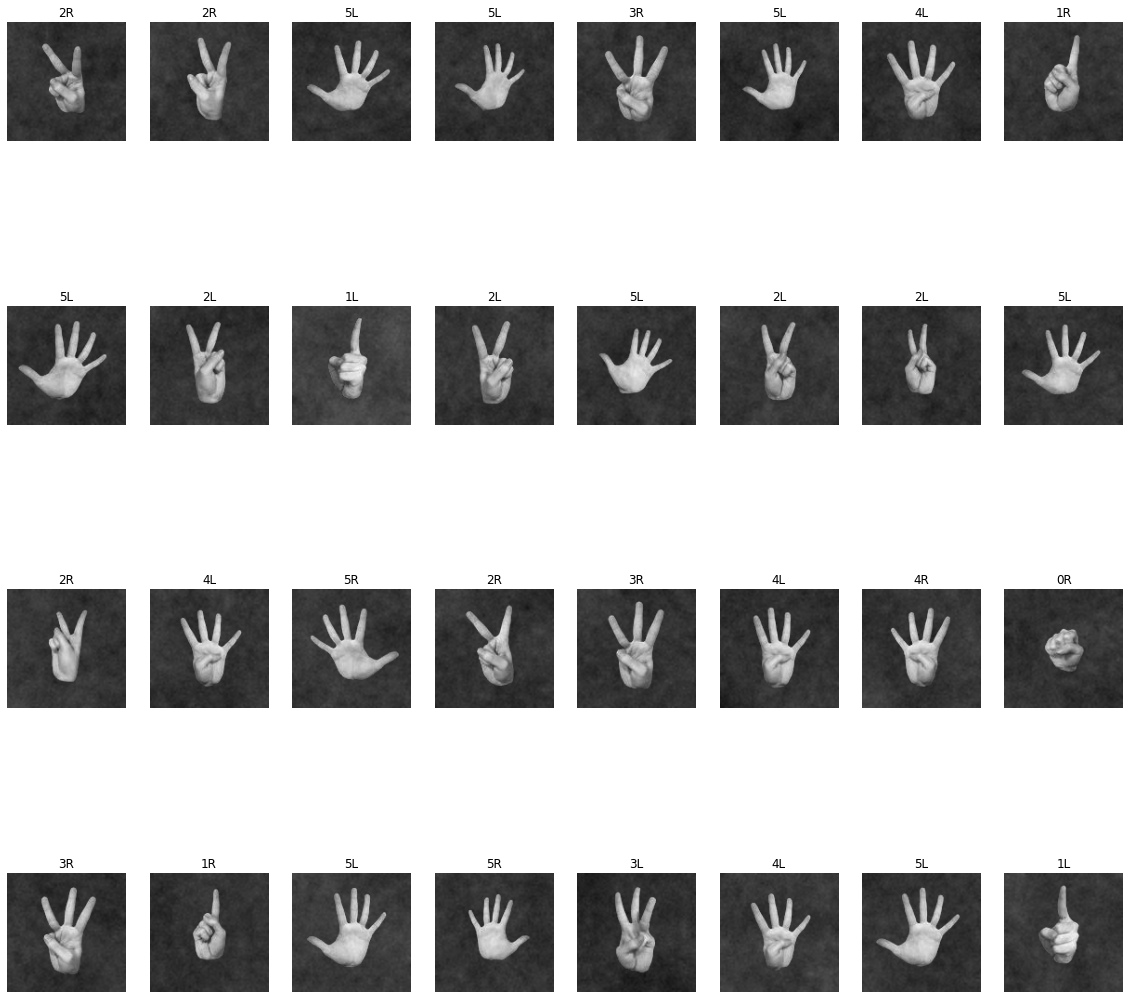

In [9]:
class_names = training_set.class_names

plt.figure(figsize = (20,20))

for image, label in training_set.take(1):
  for i in range(0,32):
    plt.subplot(4,8,i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(class_names[np.where(label[i].numpy() == 1)[0][0]])
    plt.axis('off')

plt.show()

# Importing the Test dataset

In [10]:
Batch_size = 32
Image_size = (128,128)

test_set = tf.keras.preprocessing.image_dataset_from_directory(directory = '/content/Test',
                                                                   batch_size = Batch_size,
                                                                   image_size = Image_size,
                                                                   label_mode = 'categorical')

Found 3600 files belonging to 12 classes.


### Splitting the Test Set into the Validation set and Test set

In [11]:
val_batches = test_set.cardinality()

validation_set = test_set.take(val_batches//5)

test_set = test_set.skip(val_batches//5)

print ('Number of batches in the Test set: {}'.format(test_set.cardinality().numpy()))
print ('')
print ('Number of batches in the Validation set: {}'.format(validation_set.cardinality().numpy()))

Number of batches in the Test set: 91

Number of batches in the Validation set: 22


### Configure the data to improve performance

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

training_set = training_set.prefetch(buffer_size = AUTOTUNE)
test_set = test_set.prefetch(buffer_size = AUTOTUNE)
validation_set = validation_set.prefetch(buffer_size = AUTOTUNE)

# Data Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
                                         tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
                                         tf.keras.layers.experimental.preprocessing.RandomZoom(-0.3),
                                         tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1,0.1)])

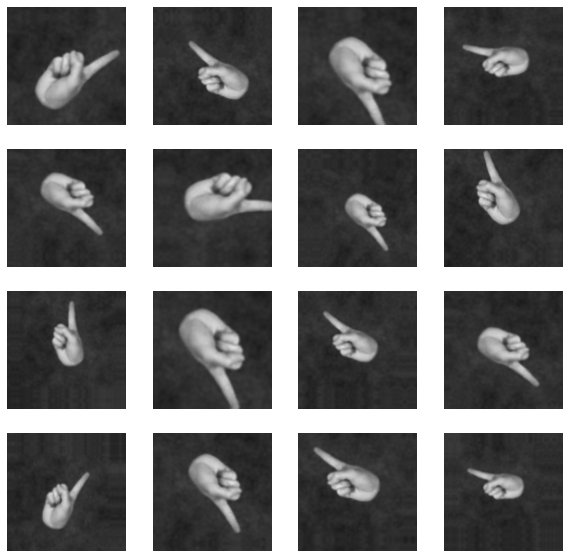

In [14]:
plt.figure(figsize = (10,10))

for image, label in training_set.take(1):
  im = image[1]
  for i in range(0,16):
    plt.subplot(4,4, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(im,0))
    plt.imshow(augmented_image[0]/255)
    plt.axis('off')

plt.show()

In [15]:
data_augmentation.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale = 1./127.5, offset = -1))

# Build the CNN

### Building the custom model

In [16]:
Input_shape_n = Image_size + (3,)

In [17]:
Model = tf.keras.Sequential()
Model.add(data_augmentation)
Model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size= 3, padding='same', activation= 'relu', input_shape = Input_shape_n))
Model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size= 3, padding='same', activation= 'relu'))
Model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = 2, padding = 'valid'))
Model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size= 3, padding='same', activation= 'relu'))
Model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = 2, padding = 'valid'))
Model.add(tf.keras.layers.Flatten())
Model.add(tf.keras.layers.Dropout(0.3))
Model.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
Model.add(tf.keras.layers.Dense(units = 12, activation = 'softmax'))

In [18]:
Model.compile(optimizer= 'Adam', 
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

In [19]:
loss0, accuracy0 = Model.evaluate(validation_set)

22/22 [==============================] - 29s 27ms/step - loss: 2.4947 - accuracy: 0.0909


In [20]:
Model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)            

In [ ]:
checkpoint_dir = '/content/checkpoints/cpkt_{epoch}'

cp_callback = tf.keras.callbacks.ModelCheckpoint( filepath = checkpoint_dir, save_weights_only= True )

In [22]:
History = Model.fit(training_set, validation_data = validation_set, epochs = 20, callbacks = [cp_callback])

Epoch 1/20
563/563 [==============================] - 48s 79ms/step - loss: 1.4992 - accuracy: 0.4249 - val_loss: 0.4725 - val_accuracy: 0.8452
Epoch 2/20
563/563 [==============================] - 44s 77ms/step - loss: 0.6084 - accuracy: 0.7513 - val_loss: 0.6894 - val_accuracy: 0.7216
Epoch 3/20
563/563 [==============================] - 44s 77ms/step - loss: 0.3871 - accuracy: 0.8437 - val_loss: 0.6854 - val_accuracy: 0.6918
Epoch 4/20
563/563 [==============================] - 44s 77ms/step - loss: 0.3195 - accuracy: 0.8748 - val_loss: 0.2177 - val_accuracy: 0.8864
Epoch 5/20
563/563 [==============================] - 44s 78ms/step - loss: 0.2570 - accuracy: 0.9012 - val_loss: 0.4702 - val_accuracy: 0.7898
Epoch 6/20
563/563 [==============================] - 44s 77ms/step - loss: 0.2319 - accuracy: 0.9116 - val_loss: 0.7723 - val_accuracy: 0.7060
Epoch 7/20
563/563 [==============================] - 44s 77ms/step - loss: 0.2069 - accuracy: 0.9209 - val_loss: 0.5192 - val_accuracy:

In [23]:
metrics=pd.DataFrame(History.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,1.499153,0.424889,0.472505,0.845170
1,0.608384,0.751333,0.689429,0.721591
2,0.387094,0.843667,0.685386,0.691761
3,0.319548,0.874833,0.217669,0.886364
4,0.257008,0.901167,0.470230,0.789773
5,0.231932,0.911556,0.772290,0.705966
6,0.206942,0.920944,0.519173,0.792614
7,0.184771,0.930444,0.154644,0.940341
8,0.173726,0.935167,0.387644,0.856534
9,0.163997,0.939222,0.286732,0.887784


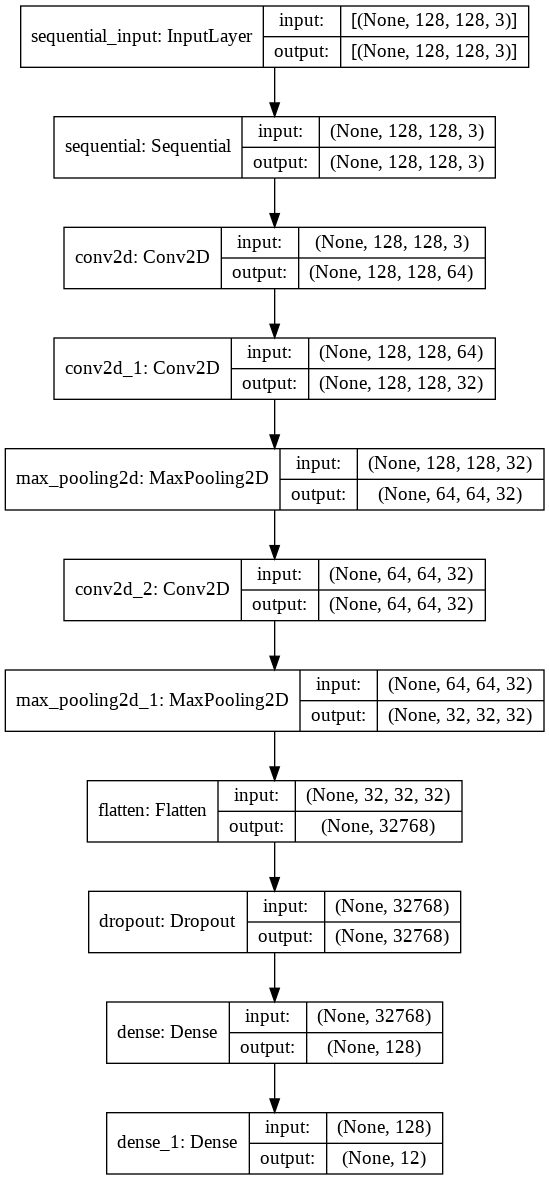

In [24]:
#Our model Plot Model
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(Model, to_file=dot_img_file, show_shapes=True)

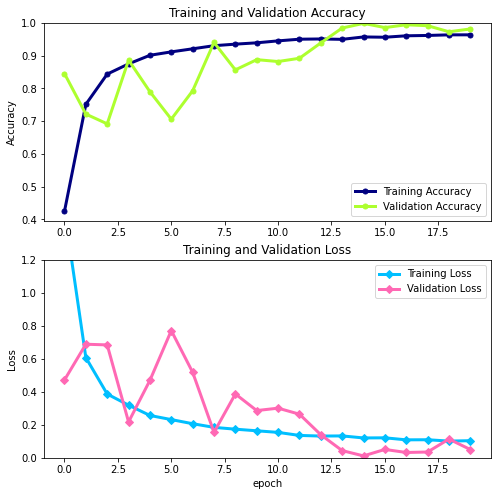

In [25]:
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']

loss = History.history['loss']
val_loss = History.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', linewidth = 3, marker = 'o', ms = 5, color = 'navy')
plt.plot(val_acc, label='Validation Accuracy',linewidth = 3, marker = 'o', ms = 5, color = 'greenyellow')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss',linewidth = 3, marker = 'D', ms = 5, color = 'deepskyblue')
plt.plot(val_loss, label='Validation Loss',linewidth = 3, marker = 'D', ms = 5, color = 'hotpink')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
Model.evaluate(test_set)

91/91 [==============================] - 4s 33ms/step - loss: 0.0574 - accuracy: 0.9782


[0.057365287095308304, 0.9782458543777466]

## Confusion Matrix

# Saving the model

In [28]:
if not os.path.exists('/content/SavedModel'):
  os.mkdir('/content/SavedModel')

In [29]:
Model.save('/content/SavedModel/Fingers.h5')

# Build CNN - ResNet 50



###  Building the model using ResNet 50

In [30]:
resnet_model = tf.keras.Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128,128,3),
                   pooling='avg',classes=12,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

94781440/94765736 [==============================] - 1s 0us/step


In [31]:
resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(128, activation='relu'))
resnet_model.add(tf.keras.layers.Dense(12, activation='softmax'))

In [32]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1548      
Total params: 23,851,532
Trainable params: 263,820
Non-trainable params: 23,587,712
_________________________________________________________________


In [33]:
resnet_model.compile(optimizer= 'Adam' ,loss='categorical_crossentropy',metrics=['accuracy'])

# (lr=0.001)

In [34]:
loss0, accuracy0 = resnet_model.evaluate(validation_set)

22/22 [==============================] - 5s 85ms/step - loss: 3.2918 - accuracy: 0.0355


In [35]:
history = resnet_model.fit(training_set, validation_data= validation_set, epochs=10)

Epoch 1/10
563/563 [==============================] - 54s 89ms/step - loss: 0.2066 - accuracy: 0.9312 - val_loss: 0.0354 - val_accuracy: 0.9901
Epoch 2/10
563/563 [==============================] - 50s 88ms/step - loss: 0.0467 - accuracy: 0.9851 - val_loss: 0.0228 - val_accuracy: 0.9929
Epoch 3/10
563/563 [==============================] - 50s 88ms/step - loss: 0.0207 - accuracy: 0.9942 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 4/10
563/563 [==============================] - 50s 88ms/step - loss: 0.0178 - accuracy: 0.9942 - val_loss: 0.0149 - val_accuracy: 0.9943
Epoch 5/10
563/563 [==============================] - 50s 88ms/step - loss: 0.0459 - accuracy: 0.9864 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 6/10
563/563 [==============================] - 50s 88ms/step - loss: 0.0118 - accuracy: 0.9969 - val_loss: 0.0426 - val_accuracy: 0.9858
Epoch 7/10
563/563 [==============================] - 49s 88ms/step - loss: 0.0150 - accuracy: 0.9956 - val_loss: 0.0115 - val_accuracy:

In [36]:
metrics=pd.DataFrame(history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.206611,0.931222,0.035355,0.990057
1,0.046691,0.985056,0.022821,0.992898
2,0.020696,0.994167,0.004193,1.000000
3,0.017840,0.994167,0.014865,0.994318
4,0.045868,0.986444,0.002666,1.000000
5,0.011753,0.996889,0.042602,0.985795
6,0.015039,0.995611,0.011487,0.994318
7,0.013285,0.996556,0.002033,1.000000
8,0.014398,0.995167,0.024519,0.992898
9,0.004124,0.999000,0.000758,1.000000


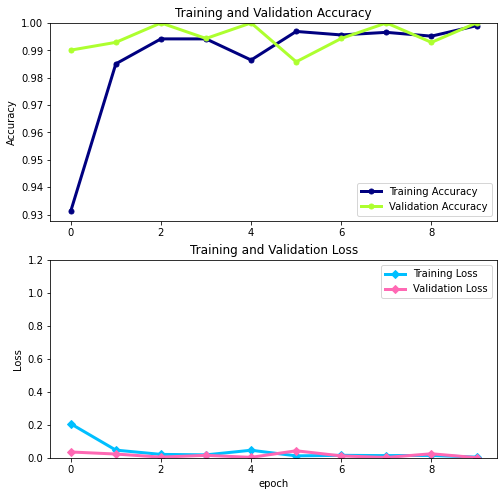

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', linewidth = 3, marker = 'o', ms = 5, color = 'navy')
plt.plot(val_acc, label='Validation Accuracy',linewidth = 3, marker = 'o', ms = 5, color = 'greenyellow')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss',linewidth = 3, marker = 'D', ms = 5, color = 'deepskyblue')
plt.plot(val_loss, label='Validation Loss',linewidth = 3, marker = 'D', ms = 5, color = 'hotpink')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
training_set

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 12)), types: (tf.float32, tf.float32)>

## Saving the ResNet 50 model

In [39]:
# save the Model weights

if not os.path.exists('/content'):
  os.mkdir('/content')

resnet_model.save('/content/Fingers_resnet.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
